This notebook contains the remaining preprocessing functions that must be applied to the sea and seism data before training any machine learning models, in line with Minio et al.'s code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from obspy.core.utcdatetime import UTCDateTime

# Clean Sea Data

In [2]:
#Load data from parquet files

path_lat = "Processed Data/SEA_data_lat.parquet"
path_lon = "Processed Data/SEA_data_lon.parquet"
path_Y = "Processed Data/SEA_data_Y.parquet"
path_time = "Processed Data/SEA_data_time.parquet"

df_lat = pd.read_parquet(path_lat)
df_lon = pd.read_parquet(path_lon)
df_Y = pd.read_parquet(path_Y)
df_time = pd.read_parquet(path_time)

In [3]:
print(df_Y.shape)

(35064, 9964)


In [4]:
nan_columns = df_Y.columns[df_Y.isna().all()]
print("Columns with all NaN values:", nan_columns.tolist())

#print(f"Number of NaN columns: {len(nan_columns)}")

Columns with all NaN values: [982, 1086, 1087, 1088, 1875, 1876, 1978, 1979, 1980, 1981, 1982, 2083, 2084, 2085, 2086, 2087, 2088, 2189, 2190, 2191, 2192, 2193, 2295, 2296, 2398, 2399, 2400, 2401, 2504, 2505, 2506, 4009, 4114, 4115, 4116, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4252, 4253, 4254, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4358, 4359, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954,

In [5]:
#Example of NaN column
#print(df_Y[982].tolist())

In [6]:
#Find latitudes and longitudes for which there is no sea data (columns of nans)

num_lat = df_lat.shape[0]
num_lon = df_lon.shape[1]

nan_lat_lon = []

for col_index in nan_columns:
    lat_index = num_lat - 1 - (col_index // num_lon) #get row index (latitude). -1 ensures correct alignment with map
    lon_index = col_index % num_lon #get column index (longitude)

    latitude = df_lat.iloc[lat_index, lon_index]
    longitude = df_lon.iloc[lat_index, lon_index]

    nan_lat_lon.append((latitude, longitude))

#print(nan_lat_lon)

C:\Users\erika\AppData\Local\Temp\ipykernel_5988\3927807446.py:11: RuntimeWarning: Mean of empty slice
  Y_avg = np.nanmean(Y, axis=0)


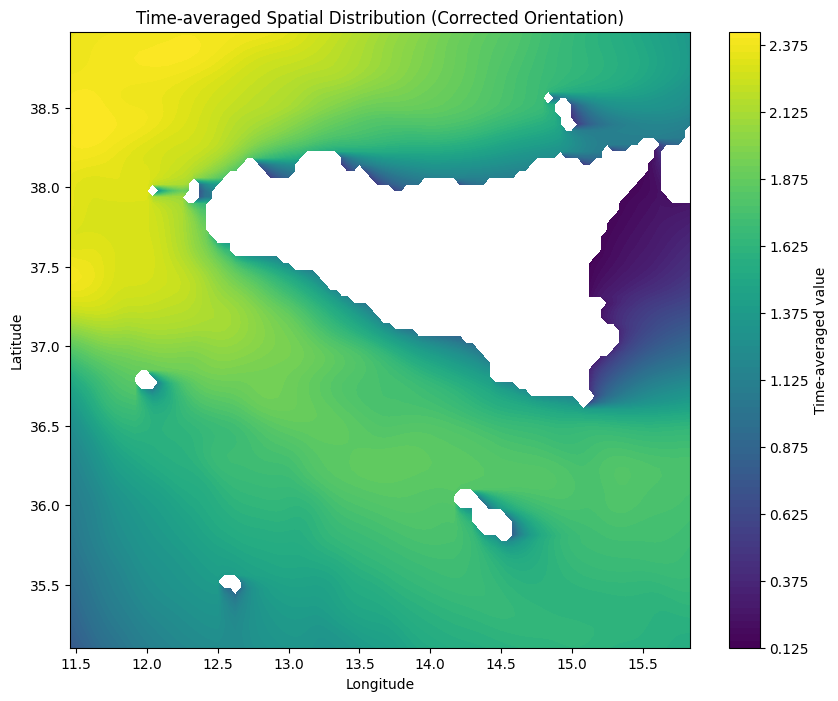

In [7]:
#Visualise 1 day of data on a map
Y = df_Y[0:24]
lat = np.array(df_lat).squeeze()
lon = np.array(df_lon).squeeze()

#Extract unique latitude and longitude values from the 2D arrays
lat = np.unique(lat[:, 0]) #Use the first column to extract unique latitudes
lon = np.unique(lon[0, :]) #Use the first row to extract unique longitudes

#Compute time-averaged data. ignoring nans. result of a whole column of nans is nan
Y_avg = np.nanmean(Y, axis=0)
Y_avg_reshaped = Y_avg.reshape(len(lat), len(lon))

#Create the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(lon, lat, Y_avg_reshaped, levels=100, cmap='viridis')
plt.colorbar(label='Time-averaged value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Time-averaged Spatial Distribution (Corrected Orientation)')
plt.show()

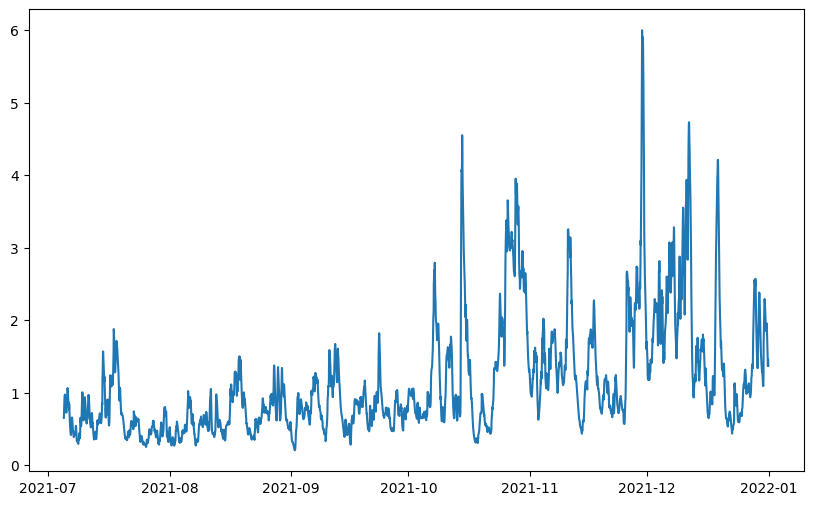

In [8]:
#Visualise 2021 H2 data to see impact of Apollo in October 2021

#get data of approx the last six months in the dataset hourly, for one location
Y_2021H2 = df_Y.iloc[-(6*30*24):,3600]

time_2021H2 = df_time.iloc[-(6*30*24):,0]

plt.figure(figsize=(10, 6))
plt.plot(time_2021H2, Y_2021H2, label='Y_2021H2')

In [9]:
num_lat = df_lat.shape[0]
num_lon = df_lon.shape[1]

col_index = 3600

lat_index = col_index // num_lon #get row index (latitude)
lon_index = col_index % num_lon #get column index (longitude)

latitude = df_lat.iloc[lat_index, lon_index]
longitude = df_lon.iloc[lat_index, lon_index]
print(latitude,longitude)

37.604168 15.708336


In [10]:
#Combining the data such that it has format date, (lat,lon) in the header row for 7,632 lat and lon pairs and 35,064 rows.
# the data won't change much, the header row will - to include lat,lon
lat_unique = df_lat.iloc[:,0].values.flatten() #take the first column of df_lat to get the unique values
lat_unique = np.sort(lat_unique) #sort smallest to largest
lon_unique = df_lon.iloc[0,:].values.flatten() #take the first row of df_lon to get the unique values

In [11]:
lat_unique

array([35.104168, 35.145836, 35.1875  , 35.229168, 35.270836, 35.3125  ,
       35.354168, 35.395836, 35.4375  , 35.479168, 35.520836, 35.5625  ,
       35.604168, 35.645836, 35.6875  , 35.729168, 35.770836, 35.8125  ,
       35.854168, 35.895836, 35.9375  , 35.979168, 36.020836, 36.0625  ,
       36.104168, 36.145836, 36.1875  , 36.229168, 36.270836, 36.3125  ,
       36.354168, 36.395836, 36.4375  , 36.479168, 36.520836, 36.5625  ,
       36.604168, 36.645836, 36.6875  , 36.729168, 36.770836, 36.8125  ,
       36.854168, 36.895836, 36.9375  , 36.979168, 37.020836, 37.0625  ,
       37.104168, 37.145836, 37.1875  , 37.229168, 37.270836, 37.3125  ,
       37.354168, 37.395836, 37.4375  , 37.479168, 37.520836, 37.5625  ,
       37.604168, 37.645836, 37.6875  , 37.729168, 37.770836, 37.8125  ,
       37.854168, 37.895836, 37.9375  , 37.979168, 38.020836, 38.0625  ,
       38.104168, 38.145836, 38.1875  , 38.229168, 38.270836, 38.3125  ,
       38.354168, 38.395836, 38.4375  , 38.479168, 

In [12]:
lon_unique

array([11.458334, 11.5     , 11.541668, 11.583334, 11.625   , 11.666668,
       11.708334, 11.75    , 11.791668, 11.833334, 11.875   , 11.916668,
       11.958334, 12.      , 12.041668, 12.083334, 12.125   , 12.166668,
       12.208334, 12.25    , 12.291668, 12.333334, 12.375   , 12.416668,
       12.458334, 12.5     , 12.541668, 12.583334, 12.625   , 12.666668,
       12.708334, 12.75    , 12.791668, 12.833334, 12.875   , 12.916668,
       12.958334, 13.      , 13.041668, 13.083334, 13.125   , 13.166668,
       13.208334, 13.25    , 13.291668, 13.333334, 13.375   , 13.416668,
       13.458334, 13.5     , 13.541668, 13.583334, 13.625   , 13.666668,
       13.708334, 13.75    , 13.791668, 13.833334, 13.875   , 13.916668,
       13.958336, 14.      , 14.041668, 14.083336, 14.125   , 14.166668,
       14.208336, 14.25    , 14.291668, 14.333336, 14.375   , 14.416668,
       14.458336, 14.5     , 14.541668, 14.583336, 14.625   , 14.666668,
       14.708336, 14.75    , 14.791668, 14.833336, 

In [13]:
lat_lon_pairs = []

for i in range(len(lat_unique)):
    for j in range(len(lon_unique)):
        lat_lon_pairs.append(f"({lat_unique[i]}, {lon_unique[j]})")

df_sea = pd.DataFrame(df_Y)

df_sea.columns = lat_lon_pairs

df_sea['time'] = df_time #add time
df_sea.set_index('time', inplace=True) #set it as index

In [14]:
df_sea.head()

(35.10416793823242, 11.458333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.637   
2018-01-01 01:00:00                                    0.637   
2018-01-01 02:00:00                                    0.623   
2018-01-01 03:00:00                                    0.602   
2018-01-01 04:00:00                                    0.567   

                     (35.10416793823242, 11.5)  \
time                                             
2018-01-01 00:00:00                      0.650   
2018-01-01 01:00:00                      0.655   
2018-01-01 02:00:00                      0.643   
2018-01-01 03:00:00                      0.623   
2018-01-01 04:00:00                      0.590   

                     (35.10416793823242, 11.541667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.665   
2018-01-01 01:00:00                                    0.671   
2018-01-01 02:00:00                                    0.663   
2018-01-01 03:00:00                                    0.645   
2018-01-01 04:00:00                                    0.613   

                     (35.10416793823242, 11.583333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.681   
2018-01-01 01:00:00                                    0.689   
2018-01-01 02:00:00                                    0.682   
2018-01-01 03:00:00                                    0.667   
2018-01-01 04:00:00                                    0.638   

                     (35.10416793823242, 11.625)  \
time                                               
2018-01-01 00:00:00                        0.694   
2018-01-01 01:00:00                        0.704   
2018-01-01 02:00:00                        0.699   
2018-01-01 03:00:00                        0.686   
2018-01-01 04:00:00                        0.660   

                     (35.10416793823242, 11.666667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.703   
2018-01-01 01:00:00                                    0.715   
2018-01-01 02:00:00                                    0.712   
2018-01-01 03:00:00                                    0.702   
2018-01-01 04:00:00                                    0.679   

                     (35.10416793823242, 11.708333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.708   
2018-01-01 01:00:00                                    0.722   
2018-01-01 02:00:00                                    0.720   
2018-01-01 03:00:00                                    0.712   
2018-01-01 04:00:00                                    0.692   

                     (35.10416793823242, 11.75)  \
time                                              
2018-01-01 00:00:00                       0.710   
2018-01-01 01:00:00                       0.724   
2018-01-01 02:00:00                       0.725   
2018-01-01 03:00:00                       0.719   
2018-01-01 04:00:00                       0.701   

                     (35.10416793823242, 11.791667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.711   
2018-01-01 01:00:00                                    0.726   
2018-01-01 02:00:00                                    0.728   
2018-01-01 03:00:00                                    0.724   
2018-01-01 04:00:00                                    0.708   

                     (35.10416793823242, 11.833333969116211)  ...  \
time                                                          ...   
2018-01-01 00:00:00                                    0.713  ...   
2018-01-01 01:00:00                           

In [15]:
df_sea.shape

(35064, 9964)

In [16]:
df_sea = df_sea.dropna(axis=1, how='all')
df_sea.shape

(35064, 8355)

# Clean RMS Data

In [17]:
#From config file of Minio

# threshold to delete ambigous rms values  
rms_thr = 1e-9 

# maximum number of nan for each column of RMS dataframe  
row_thr = 5000

In [18]:
#Load data from parquet files

path_rms = "Processed Data/RMS_data.parquet"
df_rms = pd.read_parquet(path_rms)

In [19]:
#Apart from the date column (first column), replace anything below the rms threshold with nan
df_rms.iloc[:, 1:] = df_rms.iloc[:, 1:].where(df_rms.iloc[:, 1:] >= rms_thr, np.nan)

In [20]:
#drop columns with too many missing values based on the row_thr threshold
cols_to_drop = df_rms.columns[df_rms.isnull().sum(axis=0) > row_thr]
print(len(cols_to_drop))
df_rms.drop(columns=cols_to_drop, inplace=True)

216


In [21]:
#interpolate remaining NaN values in the DataFrame
df_rms.interpolate(limit_direction='both', inplace=True)

In [22]:
print(df_rms)

                        index//  MMGO/Z/0.05-0.2  MMGO/Z/0.2-0.35  \
0     2018-01-01 00:00:00+00:00     4.045681e-07     3.843778e-07   
1     2018-01-01 01:00:00+00:00     4.112762e-07     3.559704e-07   
2     2018-01-01 02:00:00+00:00     3.688798e-07     3.330674e-07   
3     2018-01-01 03:00:00+00:00     3.875908e-07     3.249863e-07   
4     2018-01-01 04:00:00+00:00     4.028766e-07     3.277129e-07   
...                         ...              ...              ...   
35059 2021-12-31 19:00:00+00:00     6.987008e-08     8.317761e-08   
35060 2021-12-31 20:00:00+00:00     6.728398e-08     7.853731e-08   
35061 2021-12-31 21:00:00+00:00     6.677520e-08     7.818096e-08   
35062 2021-12-31 22:00:00+00:00     6.905686e-08     7.509884e-08   
35063 2021-12-31 23:00:00+00:00     7.025232e-08     7.739889e-08   

       MMGO/Z/0.35-0.5  MMGO/Z/0.5-0.65  MMGO/Z/0.65-0.8  MMGO/Z/0.8-0.95  \
0         2.295918e-07     9.958530e-08     5.443280e-08     3.380061e-08   
1         2.17546

In [23]:
print(df_rms.columns.tolist())

['index//', 'MMGO/Z/0.05-0.2', 'MMGO/Z/0.2-0.35', 'MMGO/Z/0.35-0.5', 'MMGO/Z/0.5-0.65', 'MMGO/Z/0.65-0.8', 'MMGO/Z/0.8-0.95', 'MMGO/Z/0.95-1.1', 'MMGO/Z/1.1-1.25', 'MMGO/Z/1.25-1.4', 'MMGO/Z/1.4-1.55', 'MMGO/Z/1.55-1.7', 'MMGO/Z/1.7-1.85', 'MMGO/Z/1.85-2.0', 'HAGA/Z/0.05-0.2', 'HAGA/Z/0.2-0.35', 'HAGA/Z/0.35-0.5', 'HAGA/Z/0.5-0.65', 'HAGA/Z/0.65-0.8', 'HAGA/Z/0.8-0.95', 'HAGA/Z/0.95-1.1', 'HAGA/Z/1.1-1.25', 'HAGA/Z/1.25-1.4', 'HAGA/Z/1.4-1.55', 'HAGA/Z/1.55-1.7', 'HAGA/Z/1.7-1.85', 'HAGA/Z/1.85-2.0', 'SOLUN/Z/0.05-0.2', 'SOLUN/Z/0.2-0.35', 'SOLUN/Z/0.35-0.5', 'SOLUN/Z/0.5-0.65', 'SOLUN/Z/0.65-0.8', 'SOLUN/Z/0.8-0.95', 'SOLUN/Z/0.95-1.1', 'SOLUN/Z/1.1-1.25', 'SOLUN/Z/1.25-1.4', 'SOLUN/Z/1.4-1.55', 'SOLUN/Z/1.55-1.7', 'SOLUN/Z/1.7-1.85', 'SOLUN/Z/1.85-2.0', 'CSLB/Z/0.05-0.2', 'CSLB/Z/0.2-0.35', 'CSLB/Z/0.35-0.5', 'CSLB/Z/0.5-0.65', 'CSLB/Z/0.65-0.8', 'CSLB/Z/0.8-0.95', 'CSLB/Z/0.95-1.1', 'CSLB/Z/1.1-1.25', 'CSLB/Z/1.25-1.4', 'CSLB/Z/1.4-1.55', 'MUCR/Z/0.05-0.2', 'MUCR/Z/0.2-0.35', 'MUCR/

# Skewness Correction

Before applying the skewness correction, one should look at the distribution of the data to understand if there are many small values (for example), that merit skewness correction to be applied. Using a skewness limit of 0.7, the first column MMGO/Z/0.05-0.2 would require correction. So we can investigate that to udnerstnad better.

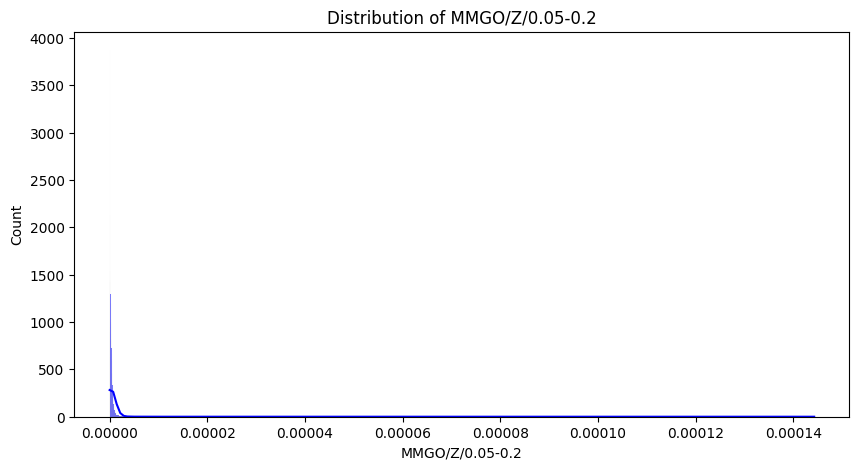

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df_rms.iloc[:, 1], kde=True, color='blue', edgecolor='black')
plt.title(f'Distribution of {df_rms.columns[1]}')
plt.xlabel(df_rms.columns[1])
plt.show()

While the data does show some skewness, RF and LGB are not affected by skewness. Therefore, we can skip skewness to shorten the data transformation pipeline that we would need to apply to new data points once the models are trained and in-use too.

In [25]:
#skewness limit used to apply box-cox transformation    
skew_limit = 0.7

In [26]:
clean_df_rms = df_rms.copy()
idx_sks = []
lmbda = []
alpha = []

In [27]:
#check skewness and apply Box-Cox transformation where necessary
for icol, col in enumerate(df_rms.columns[1:], start=1):
    skewness = df_rms[col].skew()
    
    #check if skewness exceeds the threshold
    if abs(skewness) > skew_limit:
        #apply the box-cox transformation and save results
        transformed_data, lambda_value, conf_interval = stats.boxcox(df_rms[col].dropna(), alpha=True)
        clean_df_rms.loc[df_rms[col].notna(), col] = transformed_data
        
        #append transformation information
        idx_sks.append(icol)
        lmbda.append(lambda_value)
        alpha.append(conf_interval)
        print(f"Column {col}: Skewness corrected with lambda = {lambda_value}")

print("Skewness correction completed.")

Column MMGO/Z/0.05-0.2: Skewness corrected with lambda = -0.12776762852835324
Column MMGO/Z/0.2-0.35: Skewness corrected with lambda = -0.17610724959451166
Column MMGO/Z/0.35-0.5: Skewness corrected with lambda = -0.07644634922569854
Column MMGO/Z/0.5-0.65: Skewness corrected with lambda = -0.0966932712862411
Column MMGO/Z/0.65-0.8: Skewness corrected with lambda = -0.12928675209931637
Column MMGO/Z/0.8-0.95: Skewness corrected with lambda = -0.15132697729858116
Column MMGO/Z/0.95-1.1: Skewness corrected with lambda = -0.18106303327192944
Column MMGO/Z/1.1-1.25: Skewness corrected with lambda = -0.2149157517069175
Column MMGO/Z/1.25-1.4: Skewness corrected with lambda = -0.22725225021289855
Column MMGO/Z/1.4-1.55: Skewness corrected with lambda = -0.22590700653657503
Column MMGO/Z/1.55-1.7: Skewness corrected with lambda = -0.24525002495166112
Column MMGO/Z/1.7-1.85: Skewness corrected with lambda = -0.26920195806034275
Column MMGO/Z/1.85-2.0: Skewness corrected with lambda = -0.260088

# Earthquake Catalog

In [28]:
#cnvert start and end times to strings for query
starttime = UTCDateTime('2018-01-01 00:00:00')
endtime = UTCDateTime('2021-01-31 23:59:00')

# dataframe of earthquakes for past period    
eqCatalog= "https://earthquake.usgs.gov/fdsnws/event/1/query.csv"

# number of hours used to clean the dataset from earthquake influencev   
hours_del = float(2)

# Magnitude over-threshold for regional eartquakes   
MagMed = float(5.5) 

# Magnitude over-threshold for global eartquakes  
MagWorld = float(7)

# down-limit of latitude for Sicilian Channel Sea  
lat1 = float(35.10)

# up-limit of latitude for Sicilian Channel Sea     
lat2 = float(38.09) 

# down-limit of longitude for Sicilian Channel Sea  
lon1 = float(11.45)

# up-limit of longitude  for Sicilian Channel Sea    
lon2 = float(15.87) 

In [29]:
starttime_str = starttime.strftime('%Y-%m-%dT%H:%M:%S')
endtime_str = endtime.strftime('%Y-%m-%dT%H:%M:%S')

#construct the query URL for earthquake data
query = (
    f"?starttime={starttime_str}&endtime={endtime_str}"
    f"&minmagnitude={MagMed}&orderby=time"
)
eq_url = eqCatalog + query

#load the earthquake catalog
eqs = pd.read_csv(eq_url)
print(f"Earthquake catalog loaded. Total entries: {len(eqs)}")

Earthquake catalog loaded. Total entries: 1369


In [30]:
#separate earthquakes into global and regional based on magnitude and location
eqs_world = eqs[
    (eqs['time'] >= starttime.strftime('%Y-%m-%dT%H:%M:%S')) &
    (eqs['time'] <= endtime.strftime('%Y-%m-%dT%H:%M:%S')) &
    (eqs['mag'] > MagWorld) &
    ((eqs['latitude'] < lat1) | (eqs['latitude'] > lat2) |
     (eqs['longitude'] < lon1) | (eqs['longitude'] > lon2))
]
eqs_region = eqs[
    (eqs['time'] >= starttime.strftime('%Y-%m-%dT%H:%M:%S')) &
    (eqs['time'] <= endtime.strftime('%Y-%m-%dT%H:%M:%S')) &
    (eqs['mag'] > MagMed) &
    (eqs['latitude'] >= lat1) & (eqs['latitude'] <= lat2) &
    (eqs['longitude'] >= lon1) & (eqs['longitude'] <= lon2)
]

print(f"Global earthquakes affecting data: {len(eqs_world)}")
print(f"Regional earthquakes affecting data: {len(eqs_region)}")

Global earthquakes affecting data: 30
Regional earthquakes affecting data: 0


In [31]:
#combine earthquake times
affected_times = pd.concat([eqs_region['time'], eqs_world['time']])

if not affected_times.empty:
    for quake_time in affected_times:
        #convert earthquake time to datetime and calculate the time interval to delete
        time_start = pd.to_datetime(quake_time, utc=True)
        time_end = time_start + pd.to_timedelta(hours_del, unit='h')

        if df_sea.index.tz is None:
            df_sea.index = df_sea.index.tz_localize('UTC')

        #filter out rows within the earthquake time interval
        clean_df_sea = df_sea[(df_sea.index < time_start) | (df_sea.index > time_end)]
        clean_df_rms_2 = clean_df_rms[(clean_df_rms.iloc[:,0] < time_start) | (clean_df_rms.iloc[:,0] > time_end)]

    print("Data cleaned from earthquake influence.")
else:
    print("No significant earthquakes found. Data remains unchanged.")

Data cleaned from earthquake influence.


In [32]:
clean_df_sea.to_parquet('Processed Data/SEA_data_BASELINE.parquet', engine='pyarrow', compression='snappy')
clean_df_rms_2.to_parquet('Processed Data/RMS_data_BASELINE.parquet', engine='pyarrow', compression='snappy')